In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
sns.set_style("dark")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from warnings import filterwarnings
filterwarnings('ignore')

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('data_cleaned.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]


# Use only good data

# Users could enter any number for age, so let's remove the jokers
data = data[data['age'] < 71]
data.replace(-1, np.nan, inplace=True)
data = data.dropna()

# Simplify genders down to two, for convenience
data = data[(data['gender'] < 3) & (data['gender'] > 0)]
data['gender'] = np.where(data['gender'] == 1, 'man', 'woman')

data['reliable'] = np.where(
    np.abs(data['I have frequent mood swings.'] - data['I change my mood a lot.']) > 2, 0, 1)

data = data[data.reliable == 1]
del data['reliable']

data.shape

(19011, 53)

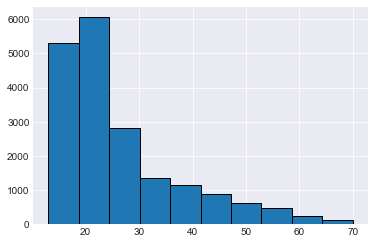

In [3]:
data['age'].hist(edgecolor='black')

In [4]:
# women.drop(['age', 'gender'], axis=1).std().sort_values().plot.barh(figsize=(5,16), grid=True)

In [5]:
# men.drop(['age', 'gender'], axis=1).std().sort_values().plot.barh(figsize=(5,16), grid=True)

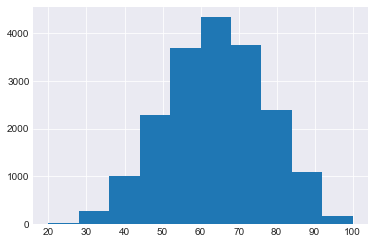

In [6]:
data['Conscientiousness'] =\
(data['I am always prepared.'] +
data['I get chores done right away.'] +
data['I like order.'] +
data['I follow a schedule.'] +
data['I am exacting in my work.'] +
(6 - data['I leave my belongings around.']) +
(6 - data['I pay attention to details.']) +
(6 - data['I make a mess of things.']) +
(6 - data['I often forget to put things back in their proper place.']) +
(6 - data['I shirk my duties.']))/.5

data['Conscientiousness'].hist()

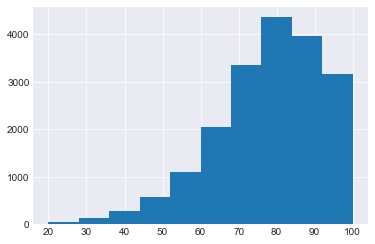

In [7]:
data['Agreeableness'] =\
(data['I take time out for others.'] +
data['I am interested in people.'] +
data["I sympathize with others' feelings."] +
data['I have a soft heart.'] +
data['I make people feel at ease.'] +
data["I feel others' emotions."] +
(6 - data["I am not interested in other people\'s problems."]) +
(6 - data["I insult people."]) +
(6 - data["I feel little concern for others."]) +
(6 - data['I am not really interested in others.']))/.5

data['Agreeableness'].hist()

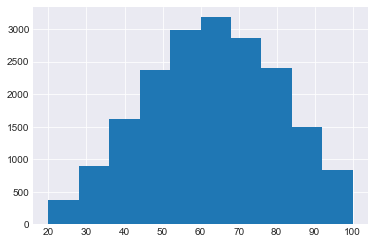

In [8]:
data['Neuroticism'] =\
(data['I get stressed out easily.'] +
data['I worry about things.'] +
data['I am easily disturbed.'] +
data['I get upset easily.'] +
data['I change my mood a lot.'] +
data['I have frequent mood swings.'] +
data['I get irritated easily.'] +
data['I often feel blue.'] +
(6 - data['I am relaxed most of the time.']) +
(6 - data['I seldom feel blue.']))/.5

data['Neuroticism'].hist()

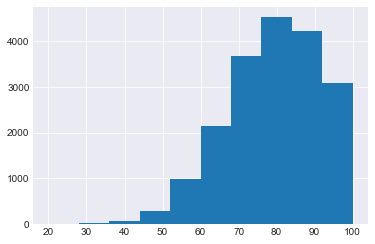

In [9]:
data['Openness'] =\
(data['I have a rich vocabulary.'] +
data['I have a vivid imagination.'] +
data['I have excellent ideas.'] +
data['I am quick to understand things.'] +
data['I use difficult words.'] +
data['I spend time reflecting on things.'] +
data['I am full of ideas.'] +
(6 - data['I have difficulty understanding abstract ideas.']) +
(6 - data['I do not have a good imagination.']) +
(6 - data['I am not interested in abstract ideas.']))/.5

data['Openness'].hist()

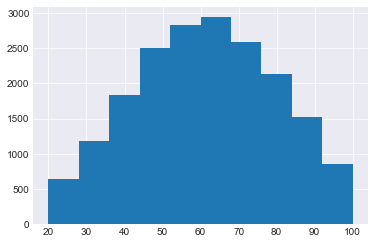

In [10]:
data['Extraversion'] =\
(data['I am the life of the party.'] +
data['I feel comfortable around people.'] +
data['I start conversations.'] +
data['I talk to a lot of different people at parties.'] +
data["I don't mind being the center of attention."] +
(6 - data["I don't like to draw attention to myself."]) +
(6 - data["I don't talk a lot."]) +
(6 - data["I have little to say."]) +
(6 - data['I am quiet around strangers.']) +
(6 - data['I keep in the background.']))/.5

data['Extraversion'].hist()

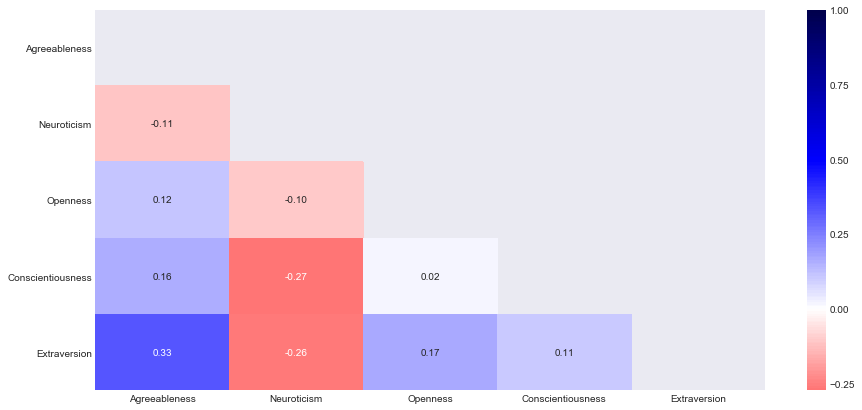

In [11]:
def correlation_matrix(df, figsize=(15,7)):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Resize and display
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, fmt='.2f', mask=mask, center=0, cmap='seismic_r')
    
traits = data[['Agreeableness', 'Neuroticism', 'Openness',
               'Conscientiousness', 'Extraversion']]

correlation_matrix(traits)

# Gender Differences

In [12]:
women = data[data.gender == 'woman']
men = data[data.gender == 'man']

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

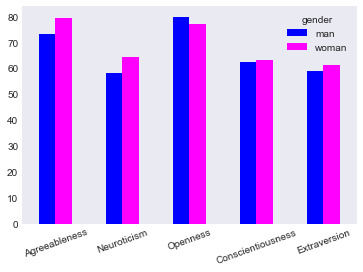

In [13]:
men_v_women = data.groupby('gender').mean()[['Agreeableness', 'Neuroticism', 'Openness',
                                             'Conscientiousness', 'Extraversion']].T

men_v_women.plot.bar(color=['blue', 'magenta'])

plt.xticks(rotation=20)

Men and women differ the most on agreeableness (which is the ability to empathize), and neuroticism (which is negative emotion). Let's graph those two.

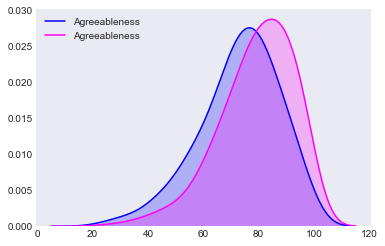

In [14]:
sns.kdeplot(men.Agreeableness, color='blue', shade=True, bw=5)
sns.kdeplot(women.Agreeableness, color='magenta', shade=True, bw=5)

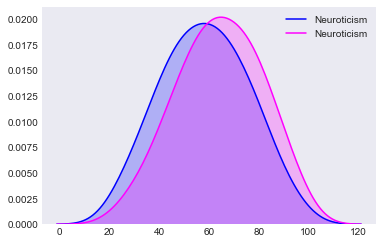

In [15]:
sns.kdeplot(men.Neuroticism, color='blue', shade=True, bw=7)
sns.kdeplot(women.Neuroticism, color='magenta', shade=True, bw=7)

# Personality over time

In [16]:
bins = np.arange(data.age.min()+1, data.age.max()+1, 10)
data['age_group'] = pd.Series(pd.cut(data['age'], bins=bins))

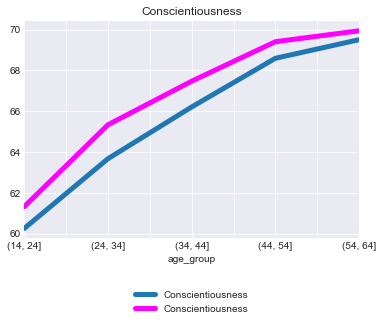

In [17]:
men_c = data[data['gender'] == 'man'].groupby('age_group').mean()
women_c = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_c['Conscientiousness'].plot(linewidth=5, grid=True)
women_c['Conscientiousness'].plot(linewidth=5, color='magenta', grid=True)

plt.title('Conscientiousness')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

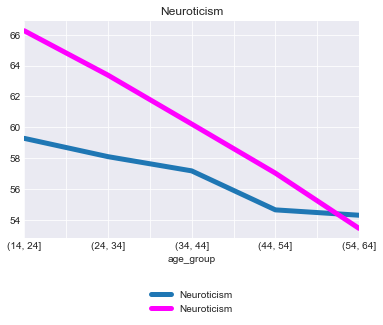

In [18]:
men_n = data[data['gender'] == 'man'].groupby('age_group').mean()
women_n = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_n['Neuroticism'].plot(linewidth=5, grid=True)
women_n['Neuroticism'].plot(linewidth=5, color='magenta', grid=True)

plt.title('Neuroticism')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

Sadly, I think there's survivorship bias when measuring neuroticism. People with poor mental health are not going to live as long. Nonetheless, our mental health seems to improve as we get older (as many formerly anxious teens will tell you).

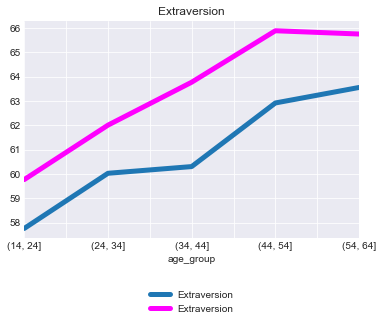

In [19]:
men_e = data[data['gender'] == 'man'].groupby('age_group').mean()
women_e = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_e['Extraversion'].plot(linewidth=5, grid=True)
women_e['Extraversion'].plot(linewidth=5, color='magenta', grid=True)

plt.title('Extraversion')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

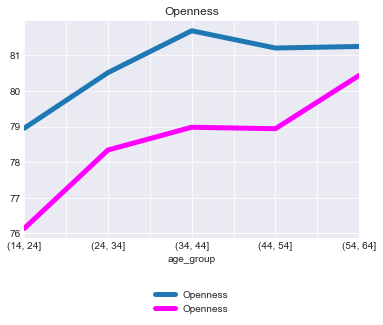

In [20]:
men_o = data[data['gender'] == 'man'].groupby('age_group').mean()
women_o = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_o['Openness'].plot(linewidth=5, grid=True)
women_o['Openness'].plot(linewidth=5, color='magenta', grid=True)

plt.title('Openness')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

I think there's some selection bias here. It would make a lot more sense if openness (which measures curiosity) declined over time. But the fact that it increases leads me to believe that intellectually curious old folks are more likely to take a personality test.

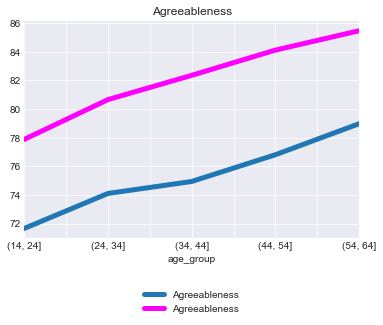

In [21]:
men_a = data[data['gender'] == 'man'].groupby('age_group').mean()
women_a = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_a['Agreeableness'].plot(linewidth=5, grid=True)
women_a['Agreeableness'].plot(linewidth=5, color='magenta', grid=True)

plt.title('Agreeableness')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

# Personality by country

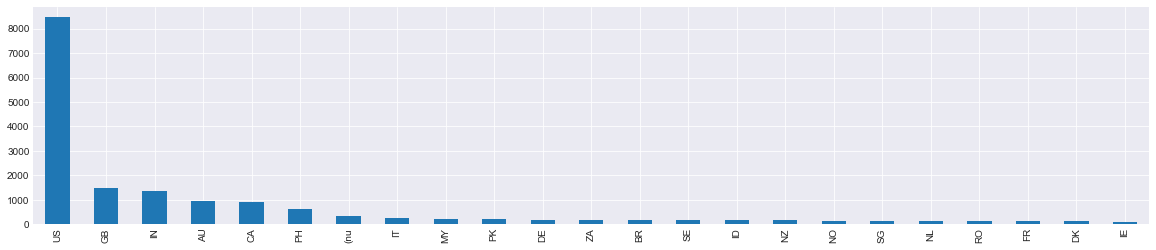

In [22]:
countries = data.country.value_counts()
countries[countries > 99].plot.bar(figsize=(20,4), grid=True)

In [23]:
top_countries = countries[countries > 99].drop('(nu').index
men = data[data.gender == 'man']
women = data[data.gender == 'woman']

### Agreeableness

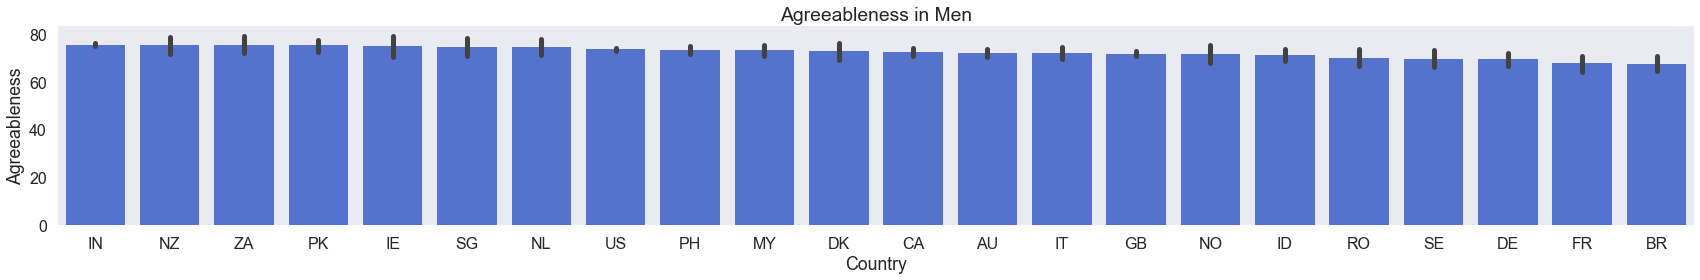

In [24]:
sns.set_context('poster')

# This sorts the countries by average male agreeableness
men_a =\
men[men.country.isin(top_countries)].groupby('country').mean()['Agreeableness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Agreeableness', data=men[men.country.isin(top_countries)]\
               .sort_values('Agreeableness', ascending=False),
               kind='bar', order=men_a,
               palette=['royalblue'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Agreeableness')

plt.title('Agreeableness in Men')

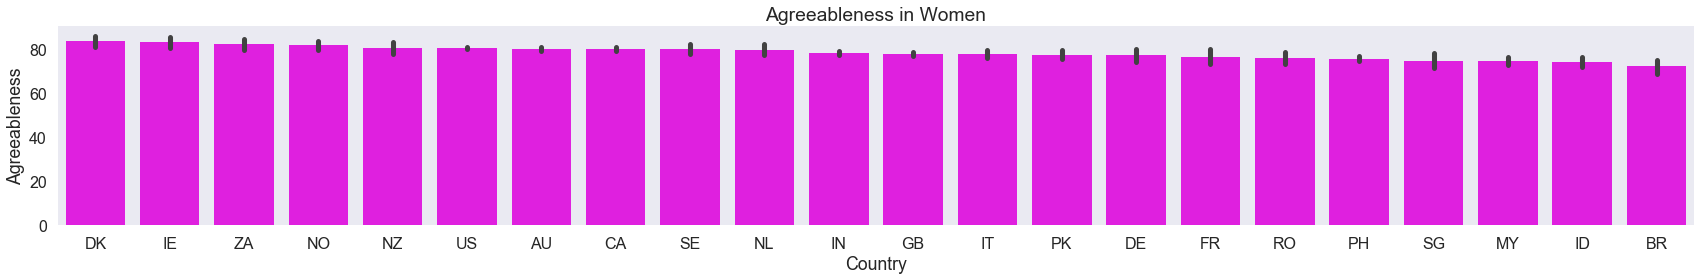

In [25]:
sns.set_context('poster')

# This sorts the countries by average female agreeableness
women_a =\
women[women.country.isin(top_countries)].groupby('country').mean()['Agreeableness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Agreeableness', data=women[women.country.isin(top_countries)]\
               .sort_values('Agreeableness', ascending=False),
               kind='bar', order=women_a,
               palette=['magenta'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Agreeableness')

plt.title('Agreeableness in Women')

### Neuroticism

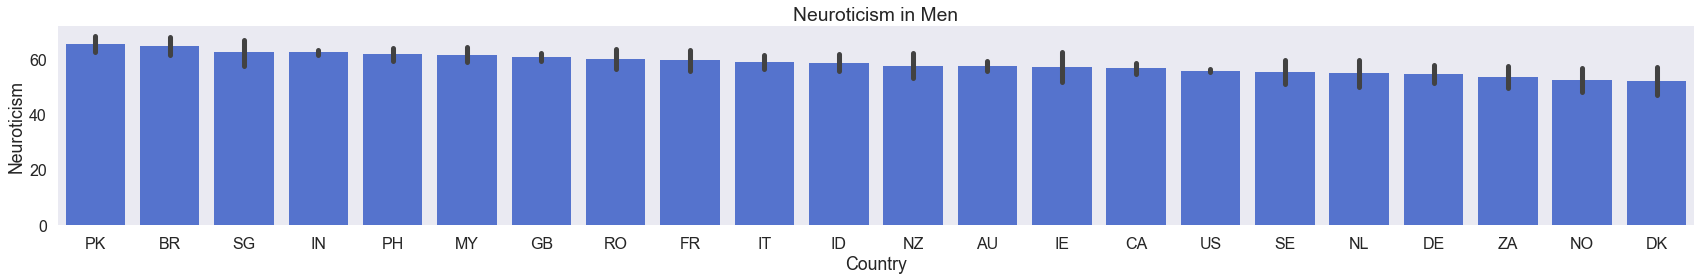

In [26]:
men_n =\
men[men.country.isin(top_countries)].groupby('country').mean()['Neuroticism']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Neuroticism', data=men[men.country.isin(top_countries)]\
               .sort_values('Neuroticism', ascending=False),
               kind='bar', order=men_n,
               palette=['royalblue'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Neuroticism')

plt.title('Neuroticism in Men')

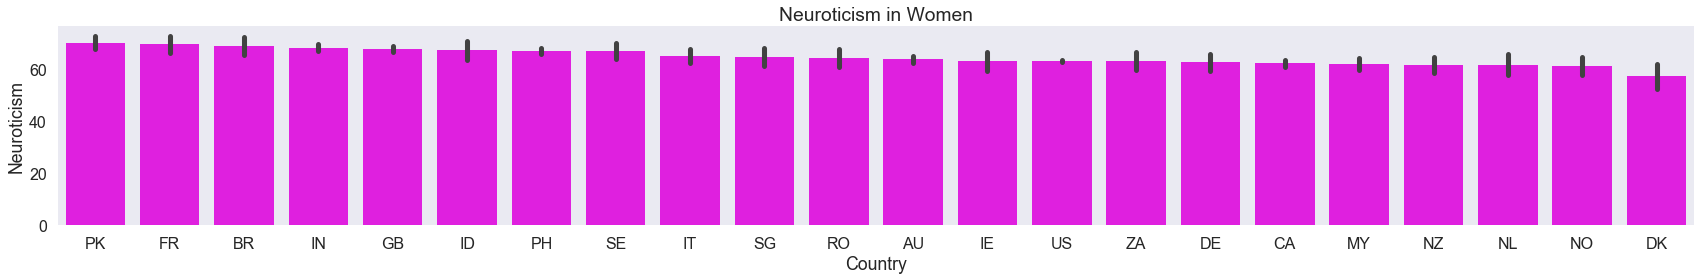

In [27]:
women_n =\
women[women.country.isin(top_countries)].groupby('country').mean()['Neuroticism']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Neuroticism', data=women[women.country.isin(top_countries)]\
               .sort_values('Neuroticism', ascending=False),
               kind='bar', order=women_n,
               palette=['magenta'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Neuroticism')

plt.title('Neuroticism in Women')

### Extraversion

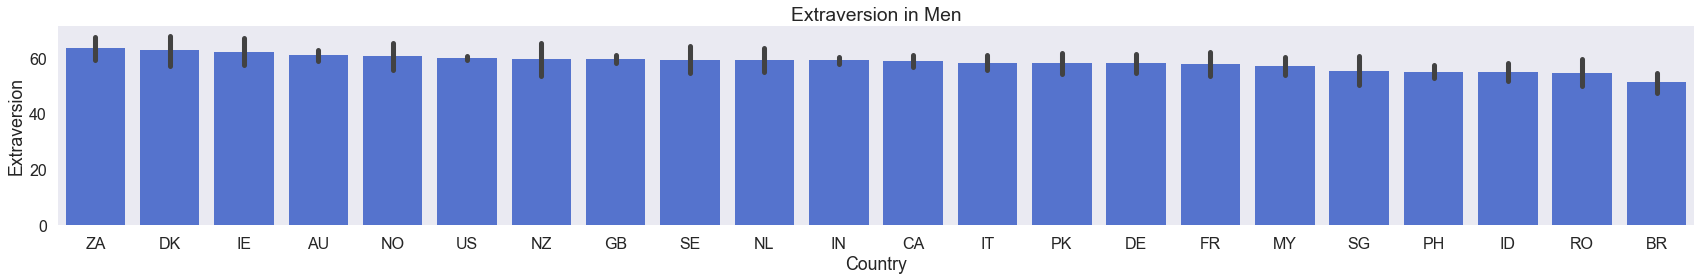

In [28]:
men_e =\
men[men.country.isin(top_countries)].groupby('country').mean()['Extraversion']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Extraversion', data=men[men.country.isin(top_countries)]\
               .sort_values('Extraversion', ascending=False),
               kind='bar', order=men_e,
               palette=['royalblue'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Extraversion')

plt.title('Extraversion in Men')

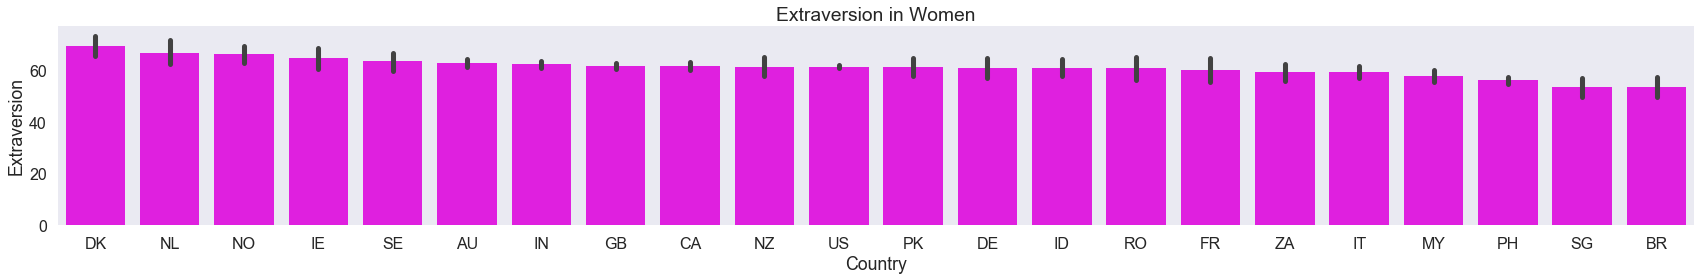

In [29]:
women_e =\
women[women.country.isin(top_countries)].groupby('country').mean()['Extraversion']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Extraversion', data=women[women.country.isin(top_countries)]\
               .sort_values('Extraversion', ascending=False),
               kind='bar', order=women_e,
               palette=['magenta'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Extraversion')

plt.title('Extraversion in Women')

### Conscientiousness

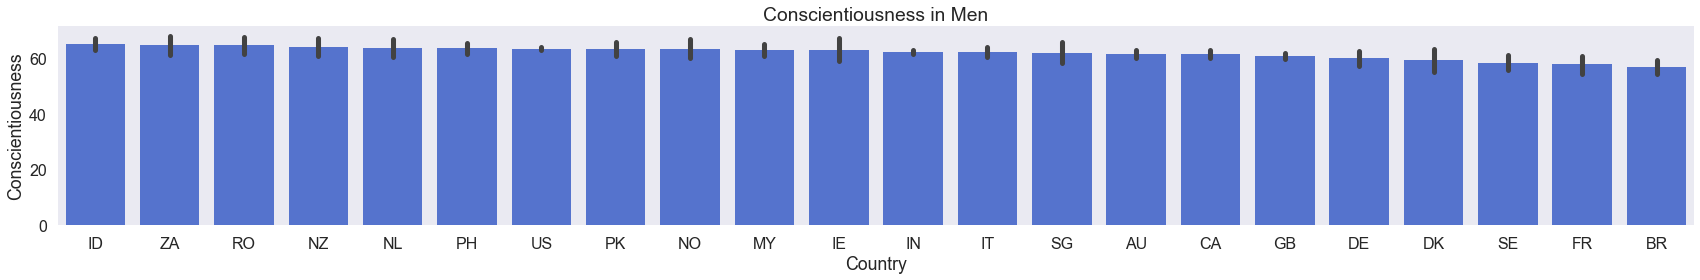

In [30]:
men_c =\
men[men.country.isin(top_countries)].groupby('country').mean()['Conscientiousness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Conscientiousness', data=men[men.country.isin(top_countries)]\
               .sort_values('Conscientiousness', ascending=False),
               kind='bar', order=men_c,
               palette=['royalblue'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Conscientiousness')

plt.title('Conscientiousness in Men')

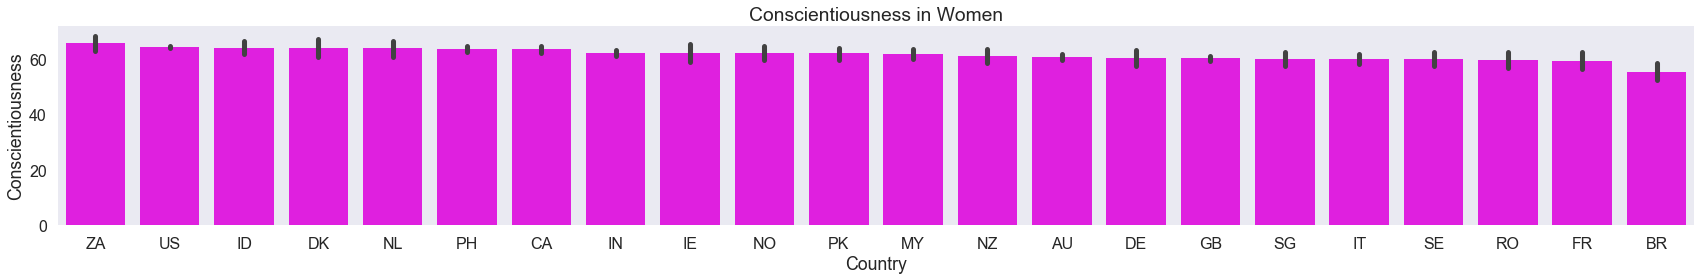

In [31]:
women_c =\
women[women.country.isin(top_countries)].groupby('country').mean()['Conscientiousness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Conscientiousness', data=women[women.country.isin(top_countries)]\
               .sort_values('Conscientiousness', ascending=False),
               kind='bar', order=women_c,
               palette=['magenta'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Conscientiousness')

plt.title('Conscientiousness in Women')

### Openness

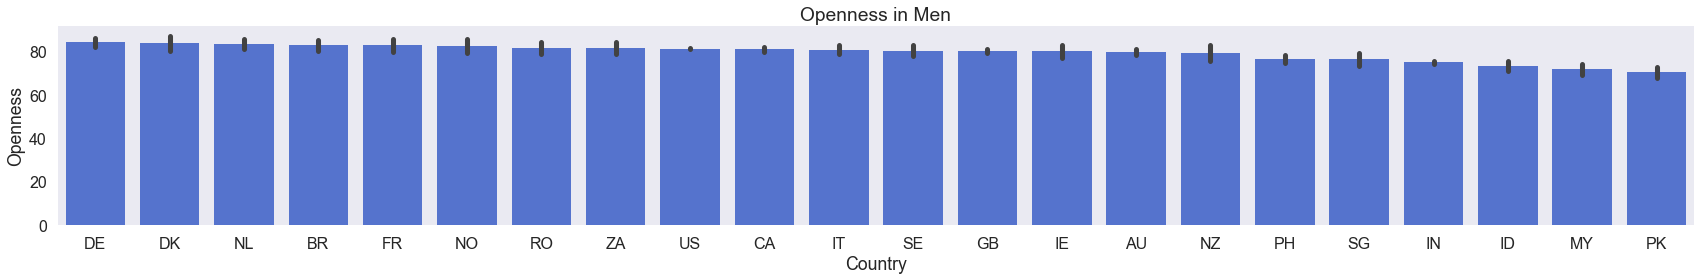

In [32]:
men_o =\
men[men.country.isin(top_countries)].groupby('country').mean()['Openness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Openness', data=men[men.country.isin(top_countries)]\
               .sort_values('Openness', ascending=False),
               kind='bar', order=men_o,
               palette=['royalblue'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Openness')

plt.title('Openness in Men')

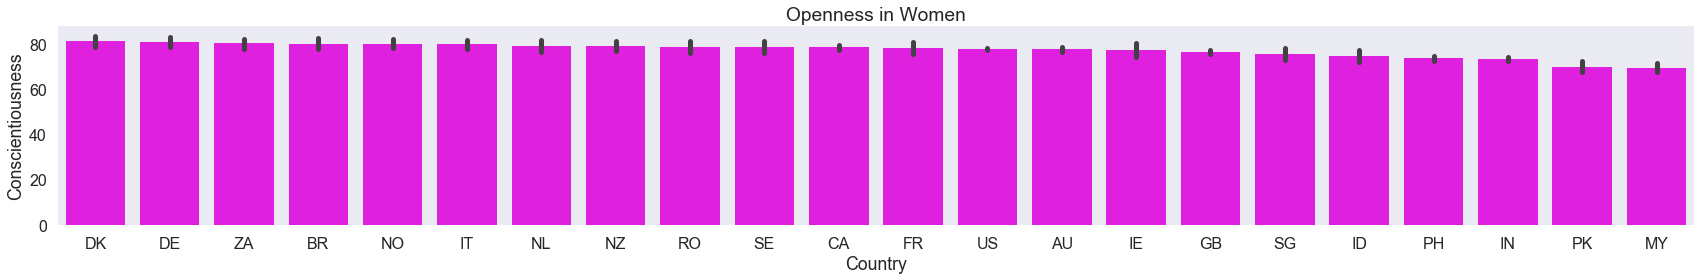

In [33]:
women_o =\
women[women.country.isin(top_countries)].groupby('country').mean()['Openness']\
.sort_values(ascending=False).index

sns.factorplot('country', 'Openness', data=women[women.country.isin(top_countries)]\
               .sort_values('Openness', ascending=False),
               kind='bar', order=women_o,
               palette=['magenta'], size=4, aspect=6)\
.set(xlabel='Country', ylabel='Conscientiousness')

plt.title('Openness in Women')

# Factor analysis

In [34]:
data = data.drop(['age', 'age_group', 'gender', 'country', 'Conscientiousness',
                  'Agreeableness', 'Neuroticism', 'Openness', 'Extraversion'], axis=1)

In [35]:
from sklearn.decomposition import FactorAnalysis

def get_factor(remaining=data.columns, threshold=0.65):

    fa = FactorAnalysis(n_components=1, random_state=200).fit(data[remaining])

    factor = pd.DataFrame(fa.components_, columns=data[remaining].columns).T

    factor.columns = [i+1 for i in factor.columns]
    factor['absol'] = abs(factor[1])
    
    remaining = factor[np.abs(factor[1]) < threshold].index
    factor = factor[factor.absol >= threshold]
    
    factor = pd.DataFrame(factor.sort_values('absol', ascending=False)[1])

    return factor, remaining

factor, remaining = get_factor(threshold=.72)

# Extraversion
factor

,1
I talk to a lot of different people at parties.,-0.990938
I start conversations.,-0.919648
I feel comfortable around people.,-0.919154
I am quiet around strangers.,0.810207
I keep in the background.,0.777479
I don't talk a lot.,0.759983
I have little to say.,0.724442


In [36]:
def intercorrelations(factor=factor):
    factor_questions = factor.index
    intercorrelations = {}

    for i in factor_questions:
        corrs = abs(data[factor_questions].drop(i, axis=1).corrwith(data[i]))
        intercorrelations[i] = corrs.mean()

    return pd.DataFrame([intercorrelations]).T.sort_values(0, ascending=False)
    
intercorrelations()

,0
I start conversations.,0.552253
I talk to a lot of different people at parties.,0.525610
I don't talk a lot.,0.507406
I keep in the background.,0.507092
I feel comfortable around people.,0.498785
I am quiet around strangers.,0.494405
I have little to say.,0.458996


In [37]:
absolute_correlations('I talk to a lot of different people at parties.', df=data)

,correlation
I start conversations.,0.634175
I am the life of the party.,0.591438
I feel comfortable around people.,0.582116
I am quiet around strangers.,-0.538342
I keep in the background.,-0.509595
I don't talk a lot.,-0.481347
I don't mind being the center of attention.,0.436464
I have little to say.,-0.408088
I am interested in people.,0.359238
I make people feel at ease.,0.354258
